# Taxi GPS data processing

In this example, we will introduce how to use the TransBigData package to efficiently process Taxi GPS data.  
Firstly, import the TransBigData and read the data using pandas

In [1]:
import transbigdata as tbd
import pandas as pd
import geopandas as gpd
#Read data
data = pd.read_csv('data/TaxiData-Sample.csv',header = None)
data.columns = ['VehicleNum','Time','Lng','Lat','OpenStatus','Speed']
data

,VehicleNum,Time,Lng,Lat,OpenStatus,Speed
0,34745,20:27:43,113.806847,22.623249,1,27
1,34745,20:24:07,113.809898,22.627399,0,0
2,34745,20:24:27,113.809898,22.627399,0,0
3,34745,20:22:07,113.811348,22.628067,0,0
4,34745,20:10:06,113.819885,22.647800,0,54
...,...,...,...,...,...,...
544994,28265,21:35:13,114.321503,22.709499,0,18
544995,28265,09:08:02,114.322701,22.681700,0,0
544996,28265,09:14:31,114.336700,22.690100,0,0
544997,28265,21:19:12,114.352600,22.728399,0,0


<AxesSubplot:>

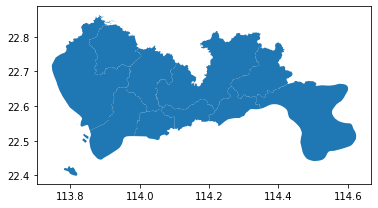

In [2]:
#Read the GeoDataFrame of the study area
import geopandas as gpd
sz = gpd.read_file(r'data/sz.json')
sz.crs = None
sz.plot()

# Data pre-processing

TransBigData integrates several common methods for data pre-processing. Using `the tbd.clean_outofshape` method, given the data and the GeoDataFrame of the study area, it can delete the data outside the study area. The `tbd.clean_taxi_status` method can filters out the data with instantaneous changes in passenger status(OpenStatus). When using the preprocessing method, the corresponding column names need to be passed in as parameters：

In [3]:
#Data Preprocessing
#Delete the data outside of the study area
data = tbd.clean_outofshape(data, sz, col=['Lng', 'Lat'], accuracy=500)
#Delete the data with instantaneous changes in passenger status
data = tbd.clean_taxi_status(data, col=['VehicleNum', 'Time', 'OpenStatus'])

# Data Gridding

The most basic way to express the data distribution is in the form of geograpic grids; after the data gridding, each GPS data point is mapped to the corresponding grid. For data gridding, you need to determine the gridding parameters at first(which can be interpreted as defining a grid coordinate system):

In [4]:
#Data gridding
#Define the bounds and generate gridding parameters
bounds = [113.6,22.4,114.8,22.9]
params = tbd.grid_params(bounds,accuracy = 500)
params


(113.6, 22.4, 0.004872390756896538, 0.004496605206422906)

After obtaining the gridding parameters, the next step is to map the GPS is to their corresponding grids. Using the `tbd.GPS_to_grids`, it will generate the `LONCOL` column and the `LATCOL` column. The two columns together can specify a grid:

In [5]:
#Mapping GPS data to grids
data['LONCOL'],data['LATCOL'] = tbd.GPS_to_grids(data['Lng'],data['Lat'],params)

Count the amount of data in each grids:

In [6]:
#Aggregate data into grids
datatest = data.groupby(['LONCOL','LATCOL'])['VehicleNum'].count().reset_index()

Generate the geometry of the grids and transform it into a GeoDataFrame:

In [7]:
#Generate the geometry for grids
datatest['geometry'] = tbd.gridid_to_polygon(datatest['LONCOL'],datatest['LATCOL'],params)
#Change it into GeoDataFrame
import geopandas as gpd
datatest = gpd.GeoDataFrame(datatest)

Plot the generated grids:



<AxesSubplot:>

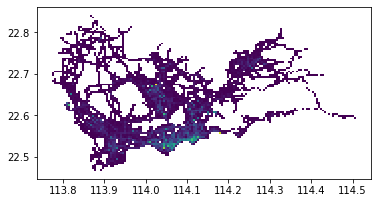

In [8]:
#Plot the grids
datatest.plot(column = 'VehicleNum')

# Origin-destination(OD) Extraction and aggregate taxi trips

Use the `tbd.taxigps_to_od` method and pass in the corresponding column name to extract the taxi trip OD:

In [9]:
#Extract taxi OD from GPS data
oddata = tbd.taxigps_to_od(data,col = ['VehicleNum','Time','Lng','Lat','OpenStatus'])
oddata

,VehicleNum,stime,slon,slat,etime,elon,elat,ID
427075,22396,00:19:41,114.013016,22.664818,00:23:01,114.021400,22.663918,0
131301,22396,00:41:51,114.021767,22.640200,00:43:44,114.026070,22.640266,1
417417,22396,00:45:44,114.028099,22.645082,00:47:44,114.030380,22.650017,2
376160,22396,01:08:26,114.034897,22.616301,01:16:34,114.035614,22.646717,3
21768,22396,01:26:06,114.046021,22.641251,01:34:48,114.066048,22.636183,4
...,...,...,...,...,...,...,...,...
57666,36805,22:37:42,114.113403,22.534767,22:48:01,114.114365,22.550632,5332
175519,36805,22:49:12,114.114365,22.550632,22:50:40,114.115501,22.557983,5333
212092,36805,22:52:07,114.115402,22.558083,23:03:27,114.118484,22.547867,5334
119041,36805,23:03:45,114.118484,22.547867,23:20:09,114.133286,22.617750,5335


Aggregate the extracted OD and generate LineString GeoDataFrame

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

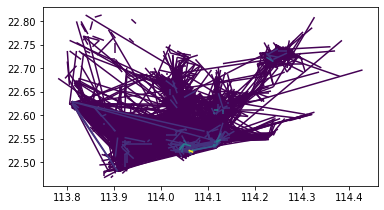

In [10]:
#Gridding and aggragate data
od_gdf = tbd.odagg_grid(oddata,params)
od_gdf.plot(column = 'count')

# Aggregate OD into polygons

`TransBigData` also provides the method for aggregating OD into polygons

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

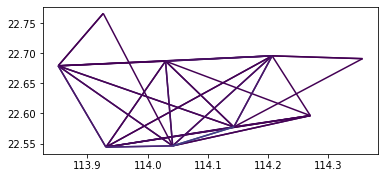

In [11]:
#Aggragate OD data to polygons (Without passing gridding parameters, the algorithm will map the data to polygons directly using their coordinates)
od_gdf = tbd.odagg_shape(oddata,sz,round_accuracy=6)
od_gdf.plot(column = 'count')

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

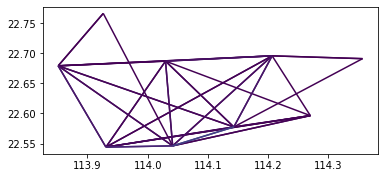

In [12]:
#Aggragate OD data to polygons (When passing  gridding parameters, the algorithm will perform data gridding before mapping data, which will speed up the mapping process)
od_gdf = tbd.odagg_shape(oddata,sz,params = params)
od_gdf.plot(column = 'count')

# Matplotlib-based map drawing

`TransBigData` also provide basemap loading in matplotlib. Before using this method, you need to set your mapboxtoken and the storage location for the basemap, see: [this link](https://transbigdata.readthedocs.io/en/latest/plot_map.html)。`tbd.plot_map` to add basemap and tbd.plotscale to add scale and compass:

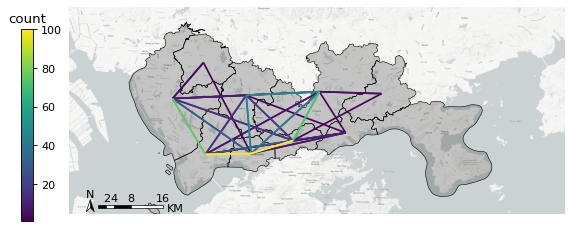

In [13]:
#Create figure
import matplotlib.pyplot as plt
import plot_map
fig =plt.figure(1,(8,8),dpi=80)
ax =plt.subplot(111)
plt.sca(ax)
#Load basemap
tbd.plot_map(plt,bounds,zoom = 12,style = 4)
#Define an ax for colorbar
cax = plt.axes([0.05, 0.33, 0.02, 0.3])
plt.title('count')
plt.sca(ax)
#Plot the OD
od_gdf.plot(ax = ax,vmax = 100,column = 'count',cax = cax,legend = True)
#Plot the polygons
sz.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0.2),linewidths=0.5)
#Add compass and scale
tbd.plotscale(ax,bounds = bounds,textsize = 10,compasssize = 1,accuracy = 2000,rect = [0.06,0.03],zorder = 10)
plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])
plt.show()

# Extraction of taxi trajectpries

Using `tbd.taxigps_traj_point` method, inputing GPS data and OD data, trajectory points can be extracted

In [14]:
data_deliver,data_idle = tbd.taxigps_traj_point(data,oddata,col=['VehicleNum', 'Time', 'Lng', 'Lat', 'OpenStatus'])

In [15]:
data_deliver

,VehicleNum,Time,Lng,Lat,OpenStatus,Speed,LONCOL,LATCOL,ID,flag
427075,22396,00:19:41,114.013016,22.664818,1,63.0,85.0,59.0,0.0,1.0
427085,22396,00:19:49,114.014030,22.665483,1,55.0,85.0,59.0,0.0,1.0
416622,22396,00:21:01,114.018898,22.662500,1,1.0,86.0,58.0,0.0,1.0
427480,22396,00:21:41,114.019348,22.662300,1,7.0,86.0,58.0,0.0,1.0
416623,22396,00:22:21,114.020615,22.663366,1,0.0,86.0,59.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
170960,36805,23:42:31,114.092766,22.538317,1,66.0,101.0,31.0,5336.0,1.0
170958,36805,23:42:37,114.091721,22.538349,1,65.0,101.0,31.0,5336.0,1.0
170974,36805,23:42:43,114.090752,22.538300,1,60.0,101.0,31.0,5336.0,1.0
170973,36805,23:42:49,114.089813,22.538099,1,62.0,101.0,31.0,5336.0,1.0


In [16]:
data_idle

,VehicleNum,Time,Lng,Lat,OpenStatus,Speed,LONCOL,LATCOL,ID,flag
416628,22396,00:23:01,114.021400,22.663918,0,25.0,86.0,59.0,0.0,0.0
401744,22396,00:25:01,114.027115,22.662100,0,25.0,88.0,58.0,0.0,0.0
394630,22396,00:25:41,114.024551,22.659834,0,21.0,87.0,58.0,0.0,0.0
394671,22396,00:26:21,114.022797,22.658367,0,0.0,87.0,57.0,0.0,0.0
394672,22396,00:26:29,114.022797,22.658367,0,0.0,87.0,57.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
64411,36805,23:53:09,114.120354,22.544300,1,2.0,107.0,32.0,5336.0,0.0
64405,36805,23:53:15,114.120354,22.544300,1,1.0,107.0,32.0,5336.0,0.0
64390,36805,23:53:21,114.120354,22.544300,1,0.0,107.0,32.0,5336.0,0.0
64406,36805,23:53:27,114.120354,22.544300,1,0.0,107.0,32.0,5336.0,0.0


Generate delivery and idle trajectories from trajectory points

<AxesSubplot:>

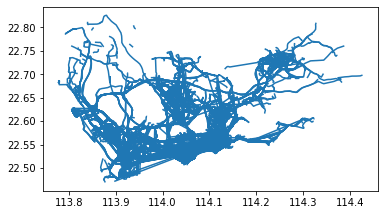

In [17]:
traj_deliver = tbd.points_to_traj(data_deliver)
traj_deliver.plot()

<AxesSubplot:>

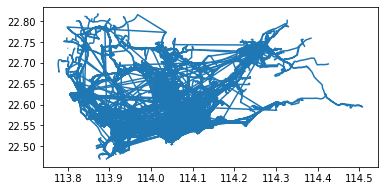

In [18]:
traj_idle = tbd.points_to_traj(data_idle[data_idle['OpenStatus'] == 0])
traj_idle.plot()

# Trajectories visualization

Built-in visualization capabilities of `TransBigData` leverage the visualization package `keplergl` to interactively visualize data on Jupyter notebook with simple code.
To use this method, please install the `keplergl` package for python. Detailed information please see [this link](https://transbigdata.readthedocs.io/en/latest/visualization.html)

Visualization of trajectory data:

In [19]:
tbd.visualization_trip(data_deliver)

整理轨迹数据...
生成可视化...
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'hizm36i', 'type': …